In [1]:
from textblob import TextBlob # librería para procesar datos de texto

print(TextBlob('I love you').sentiment.polarity)
print(TextBlob('text').sentiment.polarity)
print(TextBlob('I hate').sentiment.polarity)


0.5
0.0
-0.8


Los valores de los sentimientso estan entre (-1-1),sentimiento neutral es valor alrededor de 0, negativo es cerca de -1 y positivo es aeca de 1

In [2]:
# read in tweets data into a dataframe
import pandas as pd
# these tweets are from last May and are about Apple (AAPL)
tweets = pd.read_csv('./so_many_tweets.csv')
print(f'dimensiones: {tweets.shape}\nValores nulos: \n', tweets.isnull().sum())
tweets.head()


dimensiones: (52512, 4)
Valores nulos: 
 Text           0
Date           0
Status         0
Retweet    42471
dtype: int64


,Text,Date,Status,Retweet
0,RT @j_o_h_n_danger: $TWTR now top holding for ...,2015-05-24 03:46:08,602319644234395648,6.022899e+17
1,RT diggingplatinum RT WWalkerWW: iOS 9 vs. And...,2015-05-24 04:17:42,602327586983796737,NaN
2,RT bosocial RT insidermonkey RT j_o_h_n_danger...,2015-05-24 04:13:22,602326499534966784,NaN
3,RT @WWalkerWW: iOS 9 vs. Android M – The New F...,2015-05-24 04:08:34,602325288740114432,6.023104e+17
4,RT @seeitmarket: Apple Chart Update: Big Test ...,2015-05-24 04:04:42,602324318903771136,6.023215e+17


# **Exploratory data analysis (EDA)**
So we have four columns:
*  Text: Unstructured text at the nominal level
*  Date: Datetime (we will think of datetime in a continuous way)
*  Status: Status unique ID at the nominal level
*  Retweet: Status ID of tweet that this tweet was a retweet at the nominal level

We have 52512 rows that represents a singles tweet. Nuestro objetivo es usar el sentimiento de los tweets, por eso debemos crear dicha columna. 

In [3]:
tweets['sentiment'] = tweets.Text.apply( lambda x :TextBlob(str(x)).sentiment.polarity)

# asegurar que la columna Date sea un pd.Datetime(por todas las funciones que tiene esta clase
tweets['Date'] = pd.to_datetime(tweets.Date.apply( lambda x :str(x)[:10]))
tweets.head()

,Text,Date,Status,Retweet,sentiment
0,RT @j_o_h_n_danger: $TWTR now top holding for ...,2015-05-24,602319644234395648,6.022899e+17,0.500000
1,RT diggingplatinum RT WWalkerWW: iOS 9 vs. And...,2015-05-24,602327586983796737,NaN,0.136364
2,RT bosocial RT insidermonkey RT j_o_h_n_danger...,2015-05-24,602326499534966784,NaN,0.500000
3,RT @WWalkerWW: iOS 9 vs. Android M – The New F...,2015-05-24,602325288740114432,6.023104e+17,0.136364
4,RT @seeitmarket: Apple Chart Update: Big Test ...,2015-05-24,602324318903771136,6.023215e+17,0.000000


Ahora haremos que cada fila represente un dia de tweets

C:\Users\Manue!_PC\AppData\Local\Temp\ipykernel_25500\1350643886.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  daily_tweets = tweets.groupby('Date').mean()[{'sentiment'}]


,sentiment
Date,
2015-05-02,0.083031
2015-05-03,0.107045
2015-05-04,0.084062
2015-05-05,0.063895
2015-05-06,0.067004


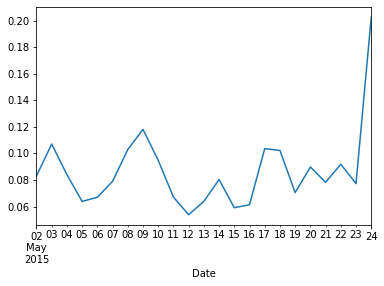

In [4]:
# create a dataframe called daily_tweets which resamples tweets by Date, averaging the columns
daily_tweets = tweets.groupby('Date').mean()[{'sentiment'}]
# I only want the sentiment column in my new Dataframe.

# plot the sentiment as a line graph
daily_tweets.sentiment.plot(kind='line')
daily_tweets.head()

In [6]:
'''obtener los preciso de las acciones en la fecha que tenemos los tweets'''

import pandas as pd
import pandas_datareader as pdr
import datetime
historical_prices = pdr.get_data_yahoo('AAPL',
                                       start=datetime.datetime(2015, 5, 2),
                                       end=datetime.datetime(2015, 5, 25))

prices = pd.DataFrame(historical_prices)
prices.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-05-04,32.642502,32.064999,32.375000,32.174999,203953200.0,29.124697
2015-05-05,32.112499,31.445000,32.037498,31.450001,197085600.0,28.468428
2015-05-06,31.687500,30.840000,31.639999,31.252501,288564000.0,28.289648
2015-05-07,31.520000,31.004999,31.192499,31.315001,175763600.0,28.464630
2015-05-08,31.905001,31.527500,31.670000,31.905001,222201600.0,29.000923


<AxesSubplot:xlabel='Date'>

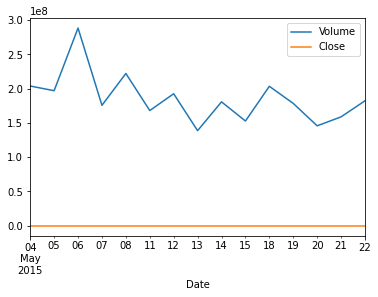

In [ ]:
prices[["Volume", 'Close']].plot()


Como vemos estas dos columnas estan en escalas muy muy diferentes 

<AxesSubplot:>

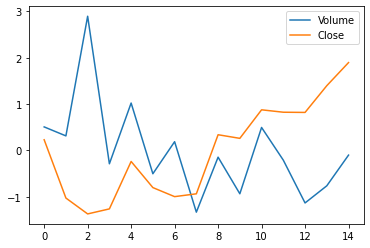

In [ ]:
from sklearn.preprocessing import StandardScaler

# scale the columns by z scores using StandardScaler
s = StandardScaler()
price_volume_scaled = s.fit_transform(prices[["Volume", 'Close']])

# Then plot the scaled data
pd.DataFrame(price_volume_scaled, columns=["Volume", 'Close']).plot()

In [ ]:
# concatinate prices.Close, and daily_tweets.sentiment
merged = pd.concat([prices.Close, daily_tweets.sentiment], axis=1)
merged.head()

,Close,sentiment
Date,,
2015-05-02,NaN,0.083031
2015-05-03,NaN,0.107045
2015-05-04,32.174999,0.084062
2015-05-05,31.450001,0.063895
2015-05-06,31.252501,0.067004


<AxesSubplot:>

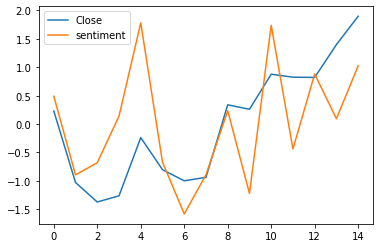

In [ ]:
# Delete any rows with missing values in any column(in close missing values of the weekend)
merged.dropna(inplace=True)

# scale the columns by z scores using StandardScaler
s = StandardScaler()
merged_scaled = s.fit_transform(merged[['Close','sentiment']])
pd.DataFrame(merged_scaled, columns=merged.columns).plot()


PArece que se mueven juntas las dos variables. vamosa aplicarle  un algoritmo de aprendizaje automatizado a ver que resultado tenemos.Un detalle es que  queremos utilizar el sentimiento de los tweets para predecir los precios de las acciones del dia siguiente.

In [ ]:

# Shift the sentiment column backwards one item
merged['yesterday_sentiment'] = merged['sentiment'].shift(1)
merged.dropna(inplace=True)
merged.head()


,Close,sentiment,yesterday_sentiment
Date,,,
2015-05-05,31.450001,0.063895,0.084062
2015-05-06,31.252501,0.067004,0.063895
2015-05-07,31.315001,0.078972,0.067004
2015-05-08,31.905001,0.102869,0.078972
2015-05-11,31.580000,0.067141,0.102869


We have two options:
*  Keep our response quantitative and use a regression analysis
*  Convert our response to a qualitative state and use classification

Si solo desea asociar el movimiento del precio es recomendable usar la via de la clasificacion, cambio si desea asociar la cantidad de movimiento es necesario usar la regresión

# **Regression Way** 
>Using RMSE as our metric

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

regression_df = merged[['yesterday_sentiment', 'Close']]
linreg = LinearRegression()
rmse_cv = abs(
    cross_val_score(
        linreg, regression_df[['yesterday_sentiment']],
        regression_df['Close'],
        cv=3, scoring='neg_root_mean_squared_error'))
rmse_cv.mean()


0.8323645463903061

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfor = RandomForestRegressor()
rmse_cv = abs(
    cross_val_score(
        rfor, regression_df[['yesterday_sentiment']],
        regression_df['Close'],
        cv=3, scoring='neg_root_mean_squared_error'))
rmse_cv.mean()


0.8420078221638119

El RMSE es aprocimadamente 0.84 en ambs modelos, lo que significa que esta fuera de de los valores casi un dolar. Una forma de comprobar la validez de nuestro modelo es comparandolo con el modelo nulo.

In [ ]:
from sklearn.metrics import mean_squared_error
# null model for regression
mean_close = regression_df['Close'].mean()
preds = [mean_close]*regression_df.shape[0]
null_rmse = np.sqrt(mean_squared_error(preds, regression_df['Close']))
null_rmse


0.595473959497161

nuestro modelo nulo tiene menos error que nuestro modelo de regresion por lo que debemos pensar en lecamino de la clasificacion. Además debemos tener em cuenta que solo tenems un conjunto de datos con 15 puntos de datos, que no esta ni de cerca de ser un numero respetable de observaciones.

# **Classification Way** 

In [ ]:

# Make a new dataframe for our classification and drop the null values
classification_df = merged[['yesterday_sentiment', 'Close']]

# variable to represent yesterday's closing price
classification_df['yesterday_close'] = classification_df['Close'].shift(1)

# column that represents the precent change in price since yesterday
classification_df['percent_change_in_price'] = (
    classification_df['Close']-classification_df['yesterday_close']) / classification_df['yesterday_close']
# drop any null values
classification_df.dropna(inplace=True)

# Our new classification response
classification_df['change_close'] = abs(classification_df['percent_change_in_price']) > .01
classification_df.head()


,yesterday_sentiment,Close,yesterday_close,percent_change_in_price,change_close
Date,,,,,
2015-05-06,0.063895,31.252501,31.450001,-0.006280,False
2015-05-07,0.067004,31.315001,31.252501,0.002000,False
2015-05-08,0.078972,31.905001,31.315001,0.018841,True
2015-05-11,0.102869,31.580000,31.905001,-0.010187,True
2015-05-12,0.067141,31.467501,31.580000,-0.003562,False


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Our accuracy as a result of cross validation random forest
rf = RandomForestClassifier()
accuracy_cv = cross_val_score(
    rf, classification_df[['yesterday_sentiment']],
    classification_df['change_close'],
    cv=3, scoring='accuracy')
accuracy_cv.mean()

0.08333333333333333

ufff. no esta nada bien pues tebenos ub 8%. Provemos con LogisticRegression 

In [ ]:
logreg = LogisticRegression()
cross_val_score(
    logreg, classification_df[['yesterday_sentiment']],
    classification_df['change_close'],
    cv=3, scoring='accuracy').mean()


0.6166666666666667

In [ ]:
# null model for classification
null_accuracy = 1 - classification_df['change_close'].mean()
null_accuracy

0.6153846153846154